## Reference
https://pennylane.ai/qml/demos/tutorial_quanvolution.html  
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/





## Pennylaneのインストール

In [1]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.1 MB/s 
     |████████████████████████████████| 15.3 MB 42.3 MB/s 
     |████████████████████████████████| 145 kB 48.4 MB/s 
     |████████████████████████████████| 1.9 MB 54.6 MB/s 


## ライブラリのインポート

In [2]:
import random
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

## 波形データ作成

In [4]:
# サンプリング数
n = 1024
t_min, t_max = 0, 0.5
t = np.linspace(0, 0.5, n)

# ノイズの大きさ
noise = 0.2

In [5]:
def create_noise_wave(t):
  y_noise = noise * np.random.randn(1)[0]
  return y_noise

In [6]:
def create_pseudo_gw_demo_v2(t, amp, s, m):
  g1 = 2
  g2 = 100
  if t < m:
      y1 = np.exp(g1*t)*(t+amp)*np.sin(300*((t+s)**2))
  else:
      y1 = np.exp(g2*(m-t))*(m*g1-t+amp)*np.sin(900*((t+s)**2))
  return y1

def create_pseudo_gw_v2(t, amp, s, m):
  y1 = create_pseudo_gw_demo_v2(t, amp, s, m)
  y_noise = noise * np.random.randn(1)[0]
  return y1 + y_noise

offset = 0.2
merge = (0.4 - offset) * np.random.rand() + offset
demo_gw_v2 = [create_pseudo_gw_demo_v2(t_i, 0.05, 0.05, merge) for t_i in t]
pseudo_gw_v2 = [create_pseudo_gw_v2(t_i, 0.05, 0.05, merge) for t_i in t]

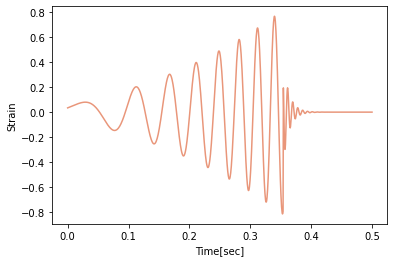

In [7]:
plt.plot(t, demo_gw_v2, color="darksalmon")
plt.xlabel("Time[sec]")
plt.ylabel("Strain")
plt.show()

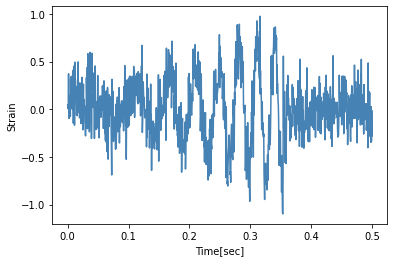

In [8]:
plt.plot(t, pseudo_gw_v2, color="steelblue")
plt.xlabel("Time[sec]")
plt.ylabel("Strain")
plt.show()

## 学習データの作成

In [9]:
# データ数
n_data = 200

In [10]:
# データの作成
for i in tqdm(range(0,n_data)):
  rand_amp = random.uniform(-0.15,0.15)
  rand_s = random.uniform(-0.15,0.15)
  rand_m = random.uniform(0.2,0.5)
  if i < (n_data // 2):
    pseudo_gw = [create_pseudo_gw_v2(t_i, rand_amp, rand_s, rand_m) for t_i in t]
    if i == 0:
      train_data = np.array(pseudo_gw)
    else:
      train_data = np.vstack([train_data, np.array(pseudo_gw)])
  else:
    noise_wave = [create_noise_wave(t_i) for t_i in t]
    train_data = np.vstack([train_data, np.array(noise_wave)])
train_data = train_data.reshape(n_data,1024,1)

100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


In [11]:
# データのラベル作成
train_label = []
for i in range(0,n_data):
  if i < (n_data // 2):
    train_label.append(1)
  else:
    train_label.append(0)

label =  np.array(train_label)

In [12]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH

In [13]:
!mkdir quanvolution

In [14]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [15]:
def quanv(image):
    # 1024個のデータをカーネルサイズ4、ストライド4で走査
    out = np.zeros((256, 4))

    for j in range(0, 1024, 4):
      q_results = circuit(
          [
            image[j, 0],
            image[j+1, 0],
            image[j+2, 0],
            image[j+3, 0]         
          ]
        )
      for c in range(4):
        out[j // 4, c] = q_results[c]
    return out

## 量子回路でデータの前処理

In [16]:
if PREPROCESS:
    q_images = []
    print("Quantum pre-processing of images:")
    for idx, img in tqdm(enumerate(train_data)):
        q_images.append(quanv(img))
    q_images = np.asarray(q_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_images.npy", q_images)

Quantum pre-processing of images:


200it [06:55,  2.08s/it]


## モデル定義

### Denseモデル　or　QNN + Denseモデル（量子回路で前処理したデータを入力した場合）

In [17]:
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### 1DCNN + Dense モデル or QNN + 1DCNN + Denseモデル（量子回路で前処理したデータを入力した場合）

In [18]:
def MyModel_with_1DCNN():
      model = keras.models.Sequential([
          keras.layers.Conv1D(filters=4, kernel_size=4, strides=4,padding="same"),
          keras.layers.BatchNormalization(),
          keras.layers.ReLU(),
          keras.layers.GlobalMaxPooling1D(),
          keras.layers.Flatten(),
          keras.layers.Dense(2, activation="softmax")
      ])

      model.compile(
          optimizer='adam',
          loss="sparse_categorical_crossentropy",
          metrics=["accuracy"],
      )
      return model

## データ準備

In [19]:
idx = np.random.permutation(np.arange(n_data))

In [20]:
n_train = 100   # Size of the train dataset
n_test = 100     # Size of the test dataset

# Load pre-processed images
q_images =  np.load(SAVE_PATH + "q_images.npy")

q_train_images = q_images[idx[:n_train]]
q_test_images = q_images[idx[-n_test:]]
train_images = train_data[idx[:n_train]]
test_images = train_data[idx[-n_test:]]
train_label = label[idx[:n_train]]
test_label = label[idx[-n_test:]]

## 学習

### Dense モデル

In [31]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_label,
    validation_data=(test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
25/25 - 1s - loss: 0.7270 - accuracy: 0.5000 - val_loss: 0.7502 - val_accuracy: 0.4800 - 519ms/epoch - 21ms/step
Epoch 2/30
25/25 - 0s - loss: 0.5965 - accuracy: 0.6900 - val_loss: 0.7398 - val_accuracy: 0.4800 - 87ms/epoch - 3ms/step
Epoch 3/30
25/25 - 0s - loss: 0.5175 - accuracy: 0.8200 - val_loss: 0.7318 - val_accuracy: 0.5000 - 93ms/epoch - 4ms/step
Epoch 4/30
25/25 - 0s - loss: 0.4480 - accuracy: 0.9300 - val_loss: 0.7200 - val_accuracy: 0.5100 - 92ms/epoch - 4ms/step
Epoch 5/30
25/25 - 0s - loss: 0.3897 - accuracy: 0.9700 - val_loss: 0.7170 - val_accuracy: 0.5300 - 96ms/epoch - 4ms/step
Epoch 6/30
25/25 - 0s - loss: 0.3460 - accuracy: 0.9900 - val_loss: 0.7194 - val_accuracy: 0.5200 - 114ms/epoch - 5ms/step
Epoch 7/30
25/25 - 0s - loss: 0.3060 - accuracy: 1.0000 - val_loss: 0.7186 - val_accuracy: 0.5100 - 111ms/epoch - 4ms/step
Epoch 8/30
25/25 - 0s - loss: 0.2728 - accuracy: 1.0000 - val_loss: 0.7222 - val_accuracy: 0.5300 - 126ms/epoch - 5ms/step
Epoch 9/30
25/25 - 

### QNN + Dense モデル

In [32]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_label,
    validation_data=(q_test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
25/25 - 0s - loss: 0.7879 - accuracy: 0.5000 - val_loss: 0.6473 - val_accuracy: 0.7100 - 439ms/epoch - 18ms/step
Epoch 2/30
25/25 - 0s - loss: 0.5596 - accuracy: 0.7000 - val_loss: 0.5383 - val_accuracy: 0.7900 - 114ms/epoch - 5ms/step
Epoch 3/30
25/25 - 0s - loss: 0.4392 - accuracy: 0.8000 - val_loss: 0.5327 - val_accuracy: 0.7600 - 86ms/epoch - 3ms/step
Epoch 4/30
25/25 - 0s - loss: 0.3742 - accuracy: 0.8800 - val_loss: 0.4676 - val_accuracy: 0.7800 - 99ms/epoch - 4ms/step
Epoch 5/30
25/25 - 0s - loss: 0.3561 - accuracy: 0.8600 - val_loss: 0.4382 - val_accuracy: 0.8000 - 118ms/epoch - 5ms/step
Epoch 6/30
25/25 - 0s - loss: 0.3306 - accuracy: 0.9200 - val_loss: 0.4323 - val_accuracy: 0.7700 - 88ms/epoch - 4ms/step
Epoch 7/30
25/25 - 0s - loss: 0.2651 - accuracy: 0.9100 - val_loss: 0.3954 - val_accuracy: 0.8500 - 89ms/epoch - 4ms/step
Epoch 8/30
25/25 - 0s - loss: 0.2669 - accuracy: 0.9500 - val_loss: 0.3768 - val_accuracy: 0.8700 - 93ms/epoch - 4ms/step
Epoch 9/30
25/25 - 0

### 1DCNN + Dense モデル

In [33]:
c1d_model = MyModel_with_1DCNN()

c1d_history = c1d_model.fit(
    train_images,
    train_label,
    validation_data=(test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
25/25 - 1s - loss: 0.6491 - accuracy: 0.6300 - val_loss: 0.5626 - val_accuracy: 0.5600 - 749ms/epoch - 30ms/step
Epoch 2/30
25/25 - 0s - loss: 0.5405 - accuracy: 0.6900 - val_loss: 0.5412 - val_accuracy: 0.6800 - 118ms/epoch - 5ms/step
Epoch 3/30
25/25 - 0s - loss: 0.4914 - accuracy: 0.7500 - val_loss: 0.5226 - val_accuracy: 0.7800 - 131ms/epoch - 5ms/step
Epoch 4/30
25/25 - 0s - loss: 0.5020 - accuracy: 0.7900 - val_loss: 0.5062 - val_accuracy: 0.8200 - 109ms/epoch - 4ms/step
Epoch 5/30
25/25 - 0s - loss: 0.4294 - accuracy: 0.8200 - val_loss: 0.4919 - val_accuracy: 0.8000 - 137ms/epoch - 5ms/step
Epoch 6/30
25/25 - 0s - loss: 0.4591 - accuracy: 0.8400 - val_loss: 0.4777 - val_accuracy: 0.7900 - 135ms/epoch - 5ms/step
Epoch 7/30
25/25 - 0s - loss: 0.4647 - accuracy: 0.8300 - val_loss: 0.4670 - val_accuracy: 0.7800 - 110ms/epoch - 4ms/step
Epoch 8/30
25/25 - 0s - loss: 0.4335 - accuracy: 0.7800 - val_loss: 0.4544 - val_accuracy: 0.8100 - 116ms/epoch - 5ms/step
Epoch 9/30
25/2

### QNN + 1DCNN + Dense モデル

In [34]:
q_and_c1d_model = MyModel_with_1DCNN()

q_and_c1d_history = q_and_c1d_model.fit(
    q_train_images,
    train_label,
    validation_data=(q_test_images, test_label),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/30
25/25 - 1s - loss: 0.7807 - accuracy: 0.5500 - val_loss: 0.6572 - val_accuracy: 0.6200 - 703ms/epoch - 28ms/step
Epoch 2/30
25/25 - 0s - loss: 0.6908 - accuracy: 0.6000 - val_loss: 0.6123 - val_accuracy: 0.7800 - 114ms/epoch - 5ms/step
Epoch 3/30
25/25 - 0s - loss: 0.6204 - accuracy: 0.6400 - val_loss: 0.5674 - val_accuracy: 0.8300 - 138ms/epoch - 6ms/step
Epoch 4/30
25/25 - 0s - loss: 0.5704 - accuracy: 0.7100 - val_loss: 0.5401 - val_accuracy: 0.8300 - 109ms/epoch - 4ms/step
Epoch 5/30
25/25 - 0s - loss: 0.5258 - accuracy: 0.7600 - val_loss: 0.4943 - val_accuracy: 0.8300 - 112ms/epoch - 4ms/step
Epoch 6/30
25/25 - 0s - loss: 0.5220 - accuracy: 0.7100 - val_loss: 0.4610 - val_accuracy: 0.8400 - 116ms/epoch - 5ms/step
Epoch 7/30
25/25 - 0s - loss: 0.4992 - accuracy: 0.7600 - val_loss: 0.4292 - val_accuracy: 0.8700 - 133ms/epoch - 5ms/step
Epoch 8/30
25/25 - 0s - loss: 0.4308 - accuracy: 0.8200 - val_loss: 0.3974 - val_accuracy: 0.9000 - 130ms/epoch - 5ms/step
Epoch 9/30
25/2

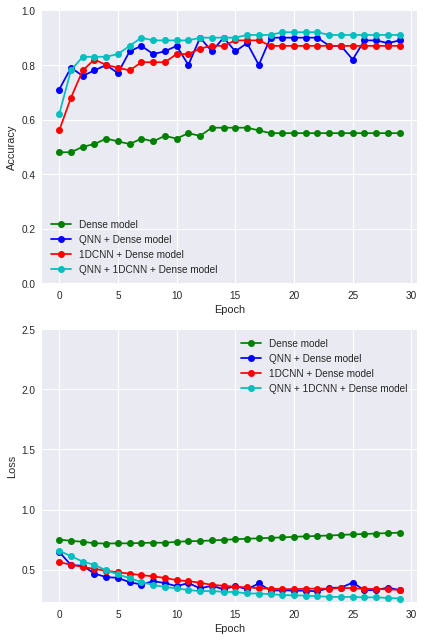

In [35]:
# 結果の描画
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(c_history.history["val_accuracy"], "-og", label="Dense model")
ax1.plot(q_history.history["val_accuracy"], "-ob", label="QNN + Dense model")
ax1.plot(c1d_history.history["val_accuracy"], "-or", label="1DCNN + Dense model")
ax1.plot(q_and_c1d_history.history["val_accuracy"], "-oc", label="QNN + 1DCNN + Dense model")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(c_history.history["val_loss"], "-og", label="Dense model")
ax2.plot(q_history.history["val_loss"], "-ob", label="QNN + Dense model")
ax2.plot(c1d_history.history["val_loss"], "-or", label="1DCNN + Dense model")
ax2.plot(q_and_c1d_history.history["val_loss"], "-oc", label="QNN + 1DCNN + Dense model")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.savefig(f'noise{noise}_train{n_train}_test{n_test}_v2.jpg')